0. Import Data

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, classification_report, confusion_matrix)

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

1. Load and Preprocess the Data

In [2]:
print("Loading MNIST dataset...")
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X = mnist.data
y = mnist.target.astype(int)

# split training set
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Further split training set
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, 
                                                  test_size=0.1, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

Loading MNIST dataset...


2. Define Models and Parameter Grids

In [3]:
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "RandomForest": RandomForestClassifier(random_state=42),
    "SVM": SVC(),
    "MLP": MLPClassifier(max_iter=100)
}

param_grids = {
    "LogisticRegression": {
        'C': [0.1, 1.0],
        'penalty': ['l2']
    },
    "KNN": {
        'n_neighbors': [3, 5],
        'weights': ['uniform', 'distance']
    },
    "RandomForest": {
        'n_estimators': [50, 100],
        'max_depth': [None, 20]
    },
    "SVM": {
        'C': [1, 10],
        'gamma': ['scale', 'auto']
    },
    "MLP": {
        'hidden_layer_sizes': [(50,), (100,)],
        'alpha': [0.0001, 0.001],
        'learning_rate_init': [0.001]
    }
}

3. Train, Tune and Evaluate Each Model

In [4]:
best_models = {}
results = []
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']

print("Starting model training and parameter tuning...")
for name, model in models.items():
    print(f"\nTuning and training {name}...")

    # Using scaled data 
    X_tr, X_val_in = X_train_scaled, X_val_scaled
    X_te = X_test_scaled
    
    grid_search = GridSearchCV(model, param_grids[name], 
                               cv=3, verbose=1, n_jobs=-1, scoring='accuracy')
    
    start_time = time.time()
    grid_search.fit(X_tr, y_train)
    training_time = time.time() - start_time
    
    best_model = grid_search.best_estimator_
    best_models[name] = best_model
    
    y_pred = best_model.predict(X_te)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro')
    rec = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    
    # Store results
    results.append((name, acc, prec, rec, f1, training_time))
    
    print(f"Best parameters for {name}: {grid_search.best_params_}")
    print(f"{name} Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

print("\nAll models trained and tuned.")



Starting model training and parameter tuning...

Tuning and training LogisticRegression...
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best parameters for LogisticRegression: {'C': 0.1, 'penalty': 'l2'}
LogisticRegression Accuracy: 0.9181, Precision: 0.9173, Recall: 0.9169, F1: 0.9170
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1343
           1       0.94      0.97      0.96      1600
           2       0.92      0.90      0.91      1380
           3       0.90      0.89      0.89      1433
           4       0.92      0.92      0.92      1295
           5       0.88      0.88      0.88      1273
           6       0.94      0.95      0.94      1396
           7       0.92      0.94      0.93      1503
           8       0.90      0.86      0.88      1357
           9       0.90      0.90      0.90      1420

    accuracy                           0.92     14000
   macro avg       0.92   

4. Compare Performance

In [5]:
# Convert results to a DataFrame
cols = ["Model", "Accuracy", "Precision", "Recall", "F1", "Training_Time(s)"]
results_df = pd.DataFrame(results, columns=cols).sort_values(by="Accuracy", ascending=False)
print("\nComparison of Models:")
print(results_df)


Comparison of Models:
                Model  Accuracy  Precision    Recall        F1  \
4                 MLP  0.969429   0.969219  0.969166  0.969173   
3                 SVM  0.969357   0.969618  0.969062  0.969265   
2        RandomForest  0.964786   0.964662  0.964451  0.964543   
1                 KNN  0.946429   0.946741  0.945678  0.946034   
0  LogisticRegression  0.918143   0.917349  0.916887  0.917022   

   Training_Time(s)  
4         83.790147  
3        924.653964  
2         49.152998  
1         44.227332  
0         36.335091  


5. Visualization of Results

i. Convert to array for easier manipulation

In [6]:
models = results_df["Model"].values
accuracy = results_df["Accuracy"].values
precision = results_df["Precision"].values
recall = results_df["Recall"].values
f1 = results_df["F1"].values

metrics_data = np.array([accuracy, precision, recall, f1])
metrics_labels = ["Accuracy", "Precision", "Recall", "F1"]


ii. Training time of models Comparison

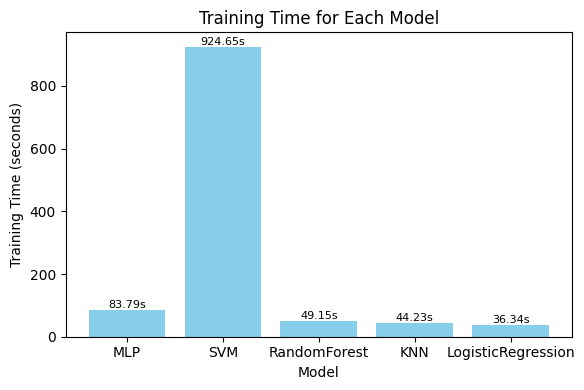

In [ ]:
plt.figure(figsize=(6,4))
plt.bar(results_df["Model"], results_df["Training_Time(s)"], color='skyblue')
plt.title("Training Time for Each Model")
plt.xlabel("Model")
plt.ylabel("Training Time (seconds)")

for i, v in enumerate(results_df["Training_Time(s)"]):
    plt.text(i, v + 1, f"{v:.2f}s", ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

iii. Comparison Bar Chart to compare metrics

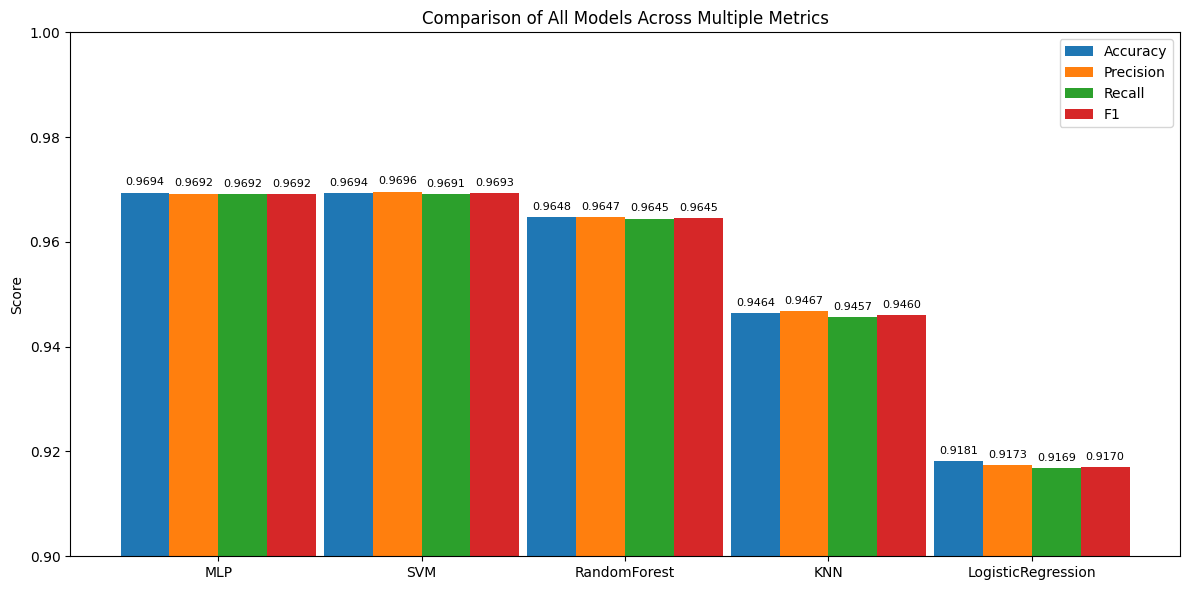

In [11]:
x = np.arange(len(models))  
width = 0.24  

fig, ax = plt.subplots(figsize=(12, 6))  

for i, metric in enumerate(metrics_data):
    ax.bar(x + (i - 1.5)*width, metric, width, label=metrics_labels[i])

ax.set_ylabel('Score')
ax.set_title('Comparison of All Models Across Multiple Metrics')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylim([0.9, 1.0])
ax.legend()

for i, metric in enumerate(metrics_data):
    for j, v in enumerate(metric):
        ax.text(j + (i - 1.5)*width, v + 0.001, f"{v:.4f}", 
                ha='center', va='bottom', fontsize=8)

plt.tight_layout() 
plt.show()


iv. Confusion Matrix Plots for Each Model

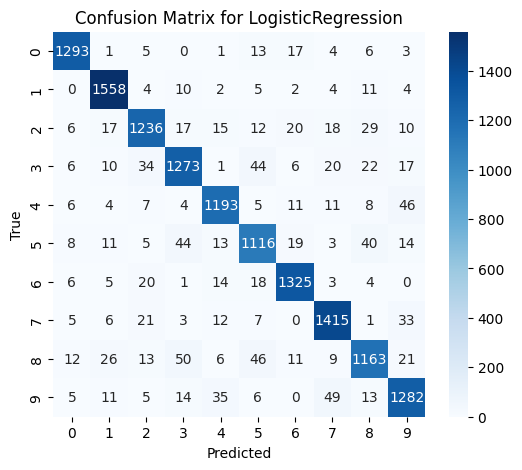

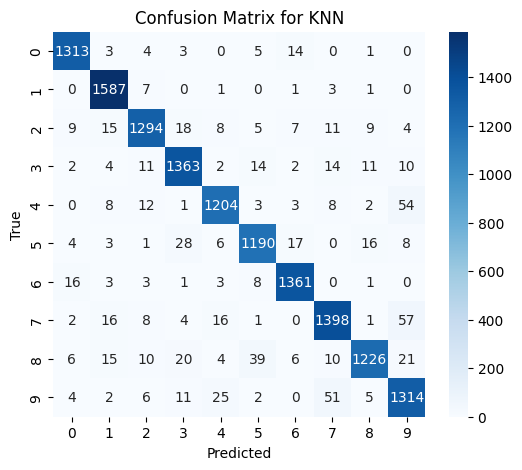

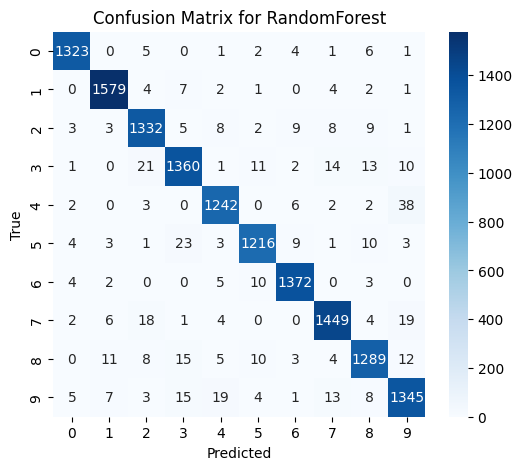

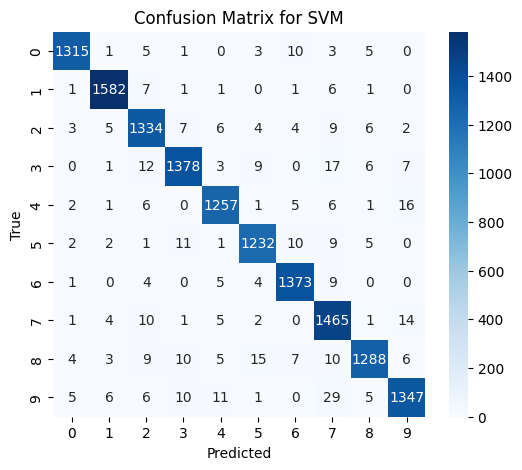

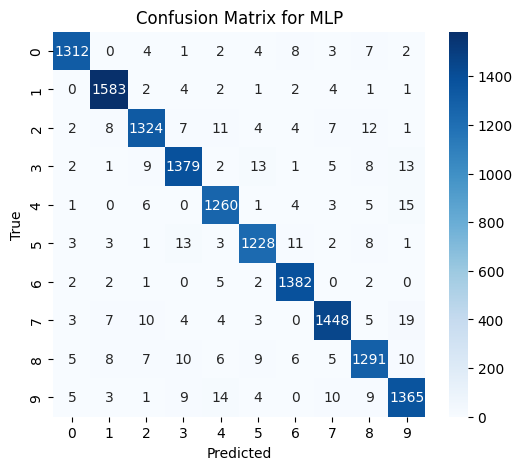

In [9]:
for name, model in best_models.items():
    y_pred = model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, y_pred)
    
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix for {name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()